# Attention-based Explainability in Turkish Text Classification

## Imports and Parameters

In [1]:
%load_ext autoreload
%autoreload 2

from itables import init_notebook_mode
init_notebook_mode(all_interactive=False)
from itables import show
import itables.options as opt
opt.style = "table-layout:auto; width:400%; margin-right:auto; margin-left:0;"
opt.columnDefs = [{"className": "dt-left", "targets": "_all"}]
opt.classes = 'display'
opt.dom = "lti"
opt.column_filters = "footer"
opt.lengthMenu = list(range(3, 250, 50))

import pandas as pd
# pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')
pd.set_option('display.max_colwidth', 100)
# pd.reset_option('display.max_colwidth')
import pickle
from tqdm.notebook import tqdm

import torch
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import sys
sys.path.append("Helper_Functions/") 
from general_utils import *
from attention_exp_utils import apply_attention
from load_models import prepare_models

<IPython.core.display.Javascript object>

In [2]:
path_config = "Config/config.json"
config = load_hyperparameters(path_config)

path_ttc4900 = config["path_ttc4900"]
path_tr_news = config["path_tr_news"]
path_interpress = config["path_interpress"]
path_tc32 = config["path_tc32"]

path_bert_model_ttc4900 = config["path_bert_model_ttc4900"]
path_bert_model_tr_news = config["path_bert_model_tr_news"] 
path_bert_model_interpress = config["path_bert_model_interpress"]
path_bert_model_tc32 = config["path_bert_model_tc32"]

path_tbt_model_ttc4900 = config["path_tbt_model_ttc4900"]
path_tbt_model_tr_news = config["path_tbt_model_tr_news"] 
path_tbt_model_interpress = config["path_tbt_model_interpress"]
path_tbt_model_tc32 = config["path_tbt_model_tc32"]

path_attention = config["path_attention"]
thresholds = config["thresholds"]
only_load = config["only_load"]

path_reports = config["path_reports"]

pipeline_parameters = config["pipeline_parameters"]
device = torch.device(config["device"]) if torch.cuda.is_available() else torch.device("cpu")

display(pd.DataFrame(list(config.items()), columns=['Parameter', 'Value']))

Parameter  \
0                 path_ttc4900   
1                 path_tr_news   
2              path_interpress   
3                    path_tc32   
4      path_bert_model_ttc4900   
5      path_bert_model_tr_news   
6   path_bert_model_interpress   
7         path_bert_model_tc32   
8       path_tbt_model_ttc4900   
9       path_tbt_model_tr_news   
10   path_tbt_model_interpress   
11         path_tbt_model_tc32   
12                   path_shap   
13                   path_lime   
14                     path_ig   
15                   path_rand   
16              path_attention   
17                path_reports   
18                  thresholds   
19                   only_load   
20                      device   
21         pipeline_parameters   

                                                               Value  
0                                                     Data/TTC_4900/  
1                                                      Data/TR_News/  
2                                                   Data/Interpress/  
3                                                         Data/TC32/  
4             Models/bertturk_text_classification_fine_tuned_ttc4900  
5             Models/bertturk_text_classification_fine_tuned_tr_news  
6          Models/bertturk_text_classification_fine_tuned_interpress  
7                Models/bertturk_text_classification_fine_tuned_tc32  
8      Models/turkishbertweet_text_classification_fine_tuned_ttc4900  
9      Models/turkishbertweet_text_classification_fine_tuned_tr_news  
10  Models/turkishbertweet_text_classification_fine_tuned_interpress  
11        Models/turkishbertweet_text_classification_fine_tuned_tc32  
12                                                    Data/Exp_SHAP/  
13                                                    Data/Exp_LIME/  
14                                                      Data/Exp_IG/  
15                                                    Data/Exp_Rand/  
16                                               Data/Exp_Attention/  
17                                                          Reports/  
18                                                   [0.5, 0.6, 0.7]  
19                                                             False  
20                                                              cuda  
21   {'padding': 'max_length', 'truncation': True, 'batch_size': 16}

## Load Datasets

In [3]:
from load_datasets import prepare_datasets

ttc4900_test, tr_news_test, interpress_test, tc32_test = prepare_datasets(path_ttc4900, path_tr_news, path_interpress, path_tc32)

print("TTC 4900 Test Set:\n\n", ttc4900_test)
print("\nTR News Test Set:\n\n", tr_news_test)
print("\nInterpress Test Set:\n\n", interpress_test)
print("\nTC 32 Test Set:\n\n", tc32_test)

TTC 4900 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 735
})

TR News Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 880
})

Interpress Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

TC 32 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 9600
})


## Attention-based Explainability

In [4]:
all_exp_results = pd.DataFrame(columns=["Cl Acc", "ECS FT", "ECS TT", "ORC (+)", "ORC (-)"])

### BERTurk

#### Inference on Full Text

In [5]:
# Load BERTurk models

bert_model_ttc4900, \
bert_tokenizer_ttc4900, \
bert_config_ttc4900, \
bert_pipeline_text_ttc4900, \
bert_label2id_ttc4900, \
bert_id2label_ttc4900 = prepare_models(path_bert_model_ttc4900, device)

bert_model_tr_news, \
bert_tokenizer_tr_news, \
bert_config_tr_news, \
bert_pipeline_text_tr_news, \
bert_label2id_tr_news, \
bert_id2label_tr_news = prepare_models(path_bert_model_tr_news, device)

bert_model_interpress, \
bert_tokenizer_interpress, \
bert_config_interpress, \
bert_pipeline_text_interpress, \
bert_label2id_interpress, \
bert_id2label_interpress = prepare_models(path_bert_model_interpress, device)

bert_model_tc32, \
bert_tokenizer_tc32, \
bert_config_tc32, \
bert_pipeline_text_tc32, \
bert_label2id_tc32, \
bert_id2label_tc32 = prepare_models(path_bert_model_tc32, device)

Error caught was: No module named 'triton'



'bertturk_text_classification_fine_tuned_ttc4900' is loaded.

'bertturk_text_classification_fine_tuned_tr_news' is loaded.

'bertturk_text_classification_fine_tuned_interpress' is loaded.

'bertturk_text_classification_fine_tuned_tc32' is loaded.


In [6]:
path_classification_results = "Data/Classification_Results/BERTurk/"

with open(path_classification_results + 'bert_full_text_preds_ttc4900.pkl', 'rb') as file:
    bert_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tr_news.pkl', 'rb') as file:
    bert_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_interpress.pkl', 'rb') as file:
    bert_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tc32.pkl', 'rb') as file:
    bert_full_text_preds_tc32 = pickle.load(file)

In [7]:
num_samples = 250

ttc4900_test = ttc4900_test.select(range(num_samples))
tr_news_test = tr_news_test.select(range(num_samples))
interpress_test = interpress_test.select(range(num_samples))
tc32_test = tc32_test.select(range(num_samples))

bert_full_text_preds_ttc4900 = bert_full_text_preds_ttc4900[:num_samples]
bert_full_text_preds_tr_news = bert_full_text_preds_tr_news[:num_samples]
bert_full_text_preds_interpress = bert_full_text_preds_interpress[:num_samples]
bert_full_text_preds_tc32 = bert_full_text_preds_tc32[:num_samples]

#### TTC4900

In [8]:
ttc4900_bert_results = {}

for threshold in thresholds:

    attention_values_ttc = apply_attention(path_attention, ttc4900_test, bert_model_ttc4900, bert_tokenizer_ttc4900, 
                                           f"attention_values_ttc_{threshold}_bert", device, only_load=only_load)
    
    top_tokens_ttc4900 = apply_thresholding(attention_values_ttc, threshold)

    ttc4900_bert_result = compare_probs(ttc4900_test,
                                        bert_full_text_preds_ttc4900,
                                        top_tokens_ttc4900,
                                        None,
                                        bert_model_ttc4900, bert_tokenizer_ttc4900,
                                        id2label=bert_id2label_ttc4900,
                                        device=device)

    ttc4900_bert_results[threshold] = (attention_values_ttc, ttc4900_bert_result)
    
    clear_gpu_memory()
    
show(ttc4900_bert_results[0.5][1])

  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_ttc_0.5_bert' saved.
'attention_values_ttc_0.5_bert' file shape: 250


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_ttc_0.6_bert' saved.
'attention_values_ttc_0.6_bert' file shape: 250


  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_ttc_0.7_bert' saved.
'attention_values_ttc_0.7_bert' file shape: 250



Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.973
Explanations Contribution Score (ECS) of Top Tokens :  0.93
Overall Relative Change (ORC) positive changes      :  2.656 %
Overall Relative Change (ORC) negative changes      : -7.822 %


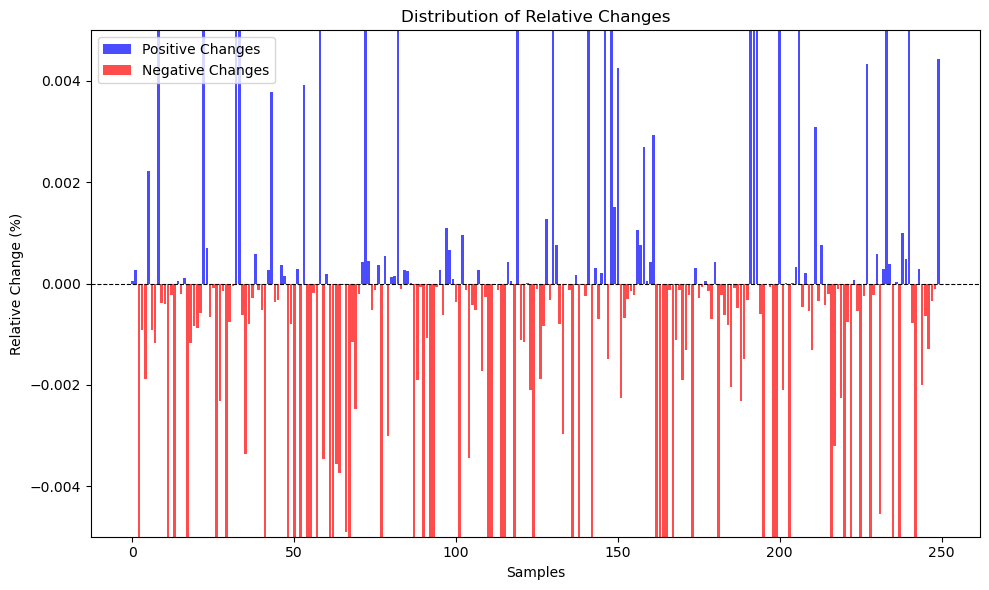


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.973
Explanations Contribution Score (ECS) of Top Tokens :  0.922
Overall Relative Change (ORC) positive changes      :  2.563 %
Overall Relative Change (ORC) negative changes      : -8.692 %


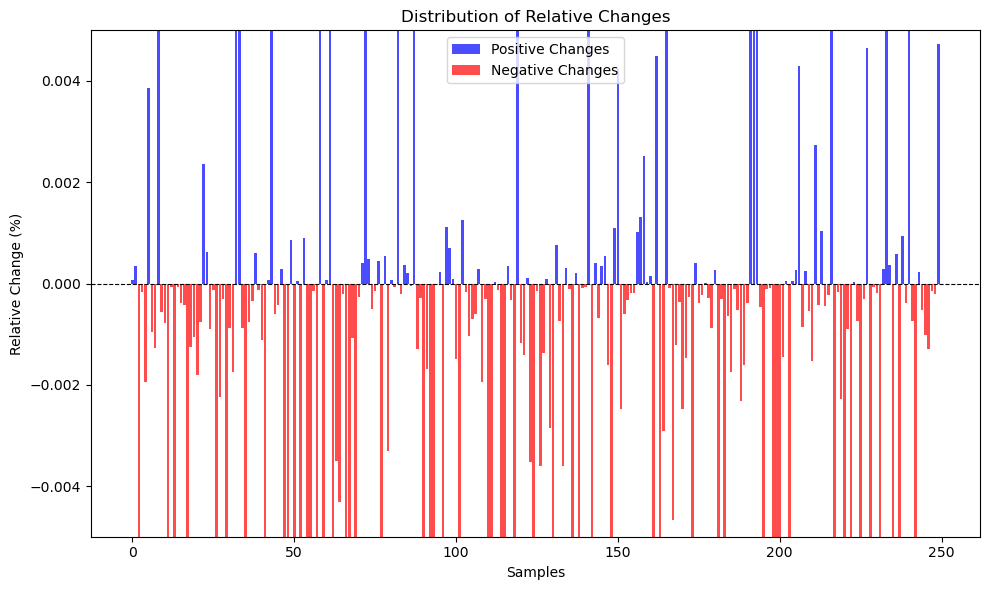


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.973
Explanations Contribution Score (ECS) of Top Tokens :  0.896
Overall Relative Change (ORC) positive changes      :  3.176 %
Overall Relative Change (ORC) negative changes      : -11.549 %


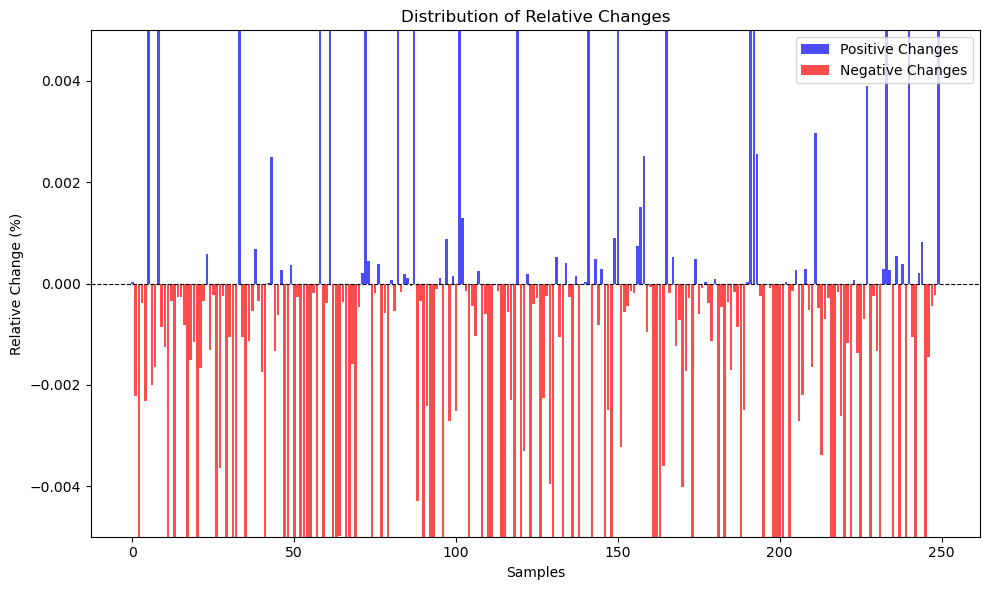

In [9]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [10]:
tr_news_bert_results = {}

for threshold in thresholds:

    attention_values_tr_news = apply_attention(path_attention, tr_news_test, bert_model_tr_news, bert_tokenizer_tr_news, 
                                               f"attention_values_tr_news_{threshold}_bert", device, only_load=only_load)
    
    top_tokens_tr_news = apply_thresholding(attention_values_tr_news, threshold)

    tr_news_bert_result = compare_probs(tr_news_test,
                                        bert_full_text_preds_tr_news,
                                        top_tokens_tr_news,
                                        None,
                                        bert_model_tr_news, bert_tokenizer_tr_news,
                                        id2label=bert_id2label_tr_news,
                                        device=device)

    tr_news_bert_results[threshold] = (attention_values_tr_news, tr_news_bert_result)
    
    clear_gpu_memory()
    
show(tr_news_bert_results[0.5][1])

  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_tr_news_0.5_bert' saved.
'attention_values_tr_news_0.5_bert' file shape: 250


  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_tr_news_0.6_bert' saved.
'attention_values_tr_news_0.6_bert' file shape: 250


  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_tr_news_0.7_bert' saved.
'attention_values_tr_news_0.7_bert' file shape: 250



Classification accuracy                             :  0.776
Explanations Contribution Score (ECS) of Full Text  :  0.856
Explanations Contribution Score (ECS) of Top Tokens :  0.714
Overall Relative Change (ORC) positive changes      :  6.253 %
Overall Relative Change (ORC) negative changes      : -20.383 %


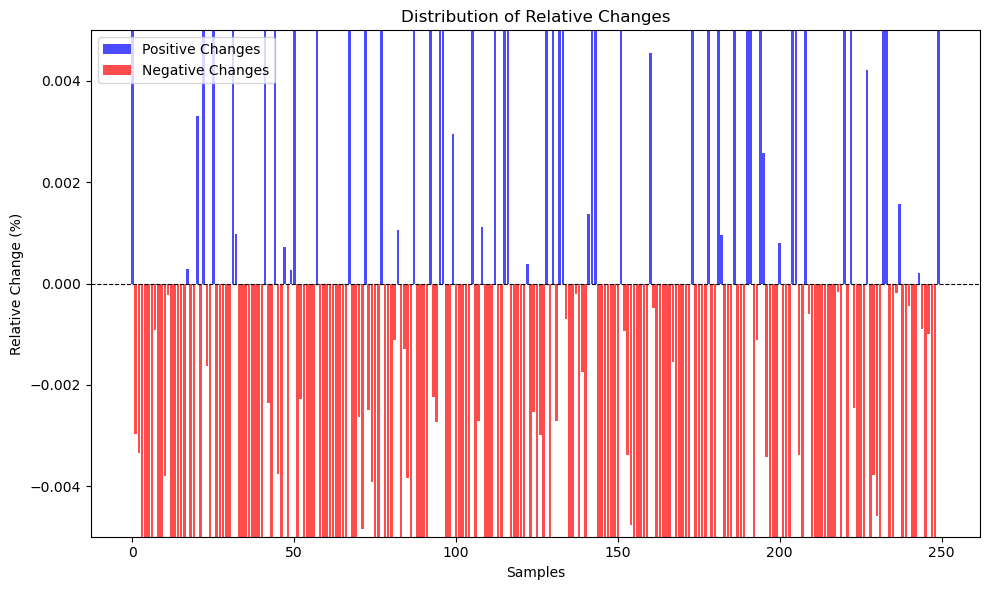


Classification accuracy                             :  0.776
Explanations Contribution Score (ECS) of Full Text  :  0.856
Explanations Contribution Score (ECS) of Top Tokens :  0.689
Overall Relative Change (ORC) positive changes      :  7.09 %
Overall Relative Change (ORC) negative changes      : -23.579 %


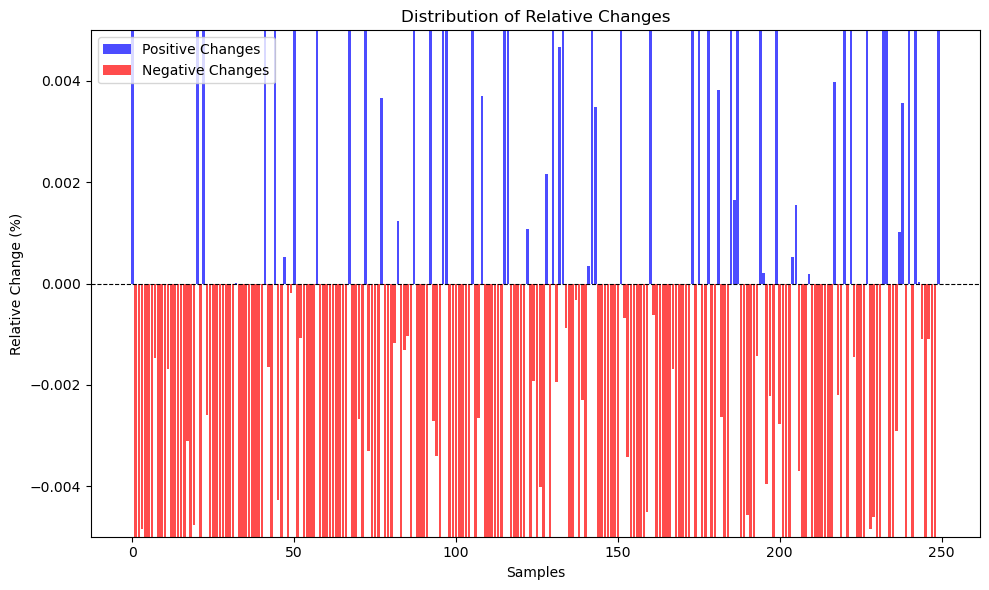


Classification accuracy                             :  0.776
Explanations Contribution Score (ECS) of Full Text  :  0.856
Explanations Contribution Score (ECS) of Top Tokens :  0.664
Overall Relative Change (ORC) positive changes      :  8.357 %
Overall Relative Change (ORC) negative changes      : -26.075 %


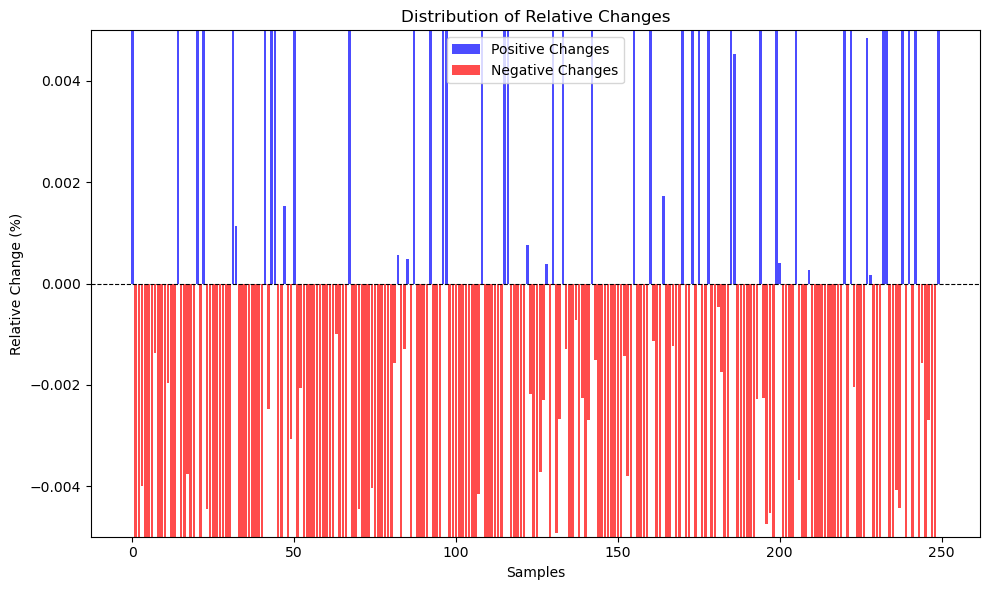

In [11]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [12]:
interpress_bert_results = {}

for threshold in thresholds:

    attention_values_interpress = apply_attention(path_attention, interpress_test, bert_model_interpress, bert_tokenizer_interpress, 
                                                  f"attention_values_interpress_{threshold}_bert", device, only_load=only_load)
    
    top_tokens_interpress = apply_thresholding(attention_values_interpress, threshold)

    interpress_bert_result = compare_probs(interpress_test,
                                           bert_full_text_preds_interpress,
                                           top_tokens_interpress,
                                           None,
                                           bert_model_interpress, bert_tokenizer_interpress,
                                           id2label=bert_id2label_interpress,
                                           device=device)

    interpress_bert_results[threshold] = (attention_values_interpress, interpress_bert_result)
    
    clear_gpu_memory()
    
show(interpress_bert_results[0.5][1])

  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_interpress_0.5_bert' saved.
'attention_values_interpress_0.5_bert' file shape: 250


  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_interpress_0.6_bert' saved.
'attention_values_interpress_0.6_bert' file shape: 250


  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_interpress_0.7_bert' saved.
'attention_values_interpress_0.7_bert' file shape: 250



Classification accuracy                             :  0.852
Explanations Contribution Score (ECS) of Full Text  :  0.927
Explanations Contribution Score (ECS) of Top Tokens :  0.843
Overall Relative Change (ORC) positive changes      :  4.442 %
Overall Relative Change (ORC) negative changes      : -16.496 %


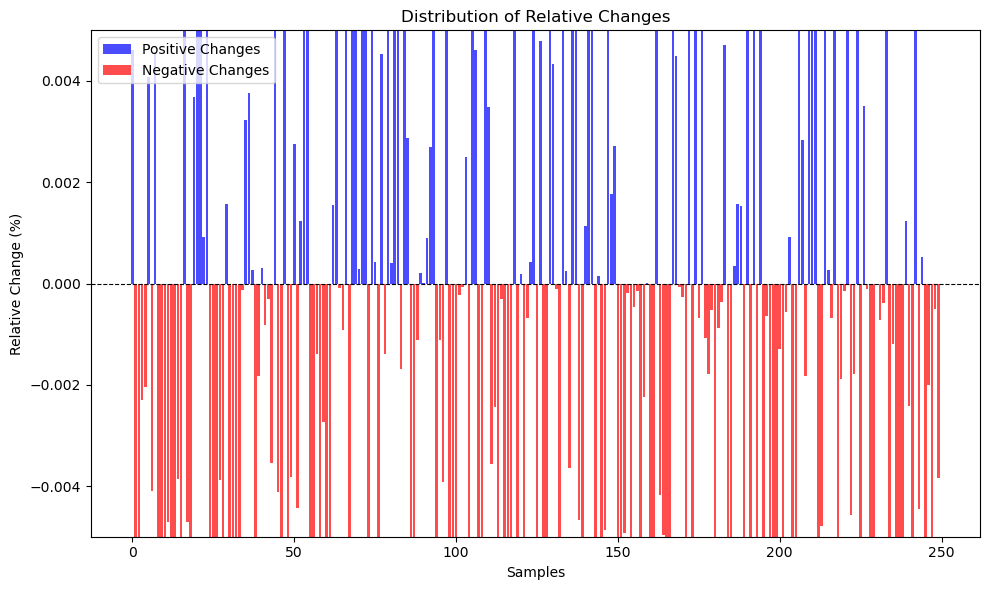


Classification accuracy                             :  0.852
Explanations Contribution Score (ECS) of Full Text  :  0.927
Explanations Contribution Score (ECS) of Top Tokens :  0.843
Overall Relative Change (ORC) positive changes      :  5.163 %
Overall Relative Change (ORC) negative changes      : -16.224 %


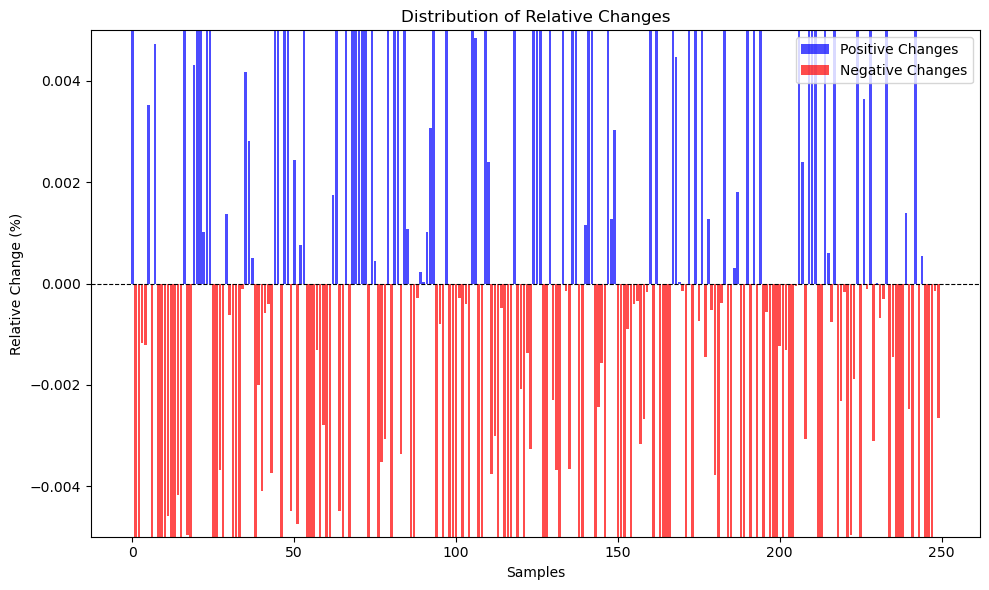


Classification accuracy                             :  0.852
Explanations Contribution Score (ECS) of Full Text  :  0.927
Explanations Contribution Score (ECS) of Top Tokens :  0.823
Overall Relative Change (ORC) positive changes      :  5.001 %
Overall Relative Change (ORC) negative changes      : -18.838 %


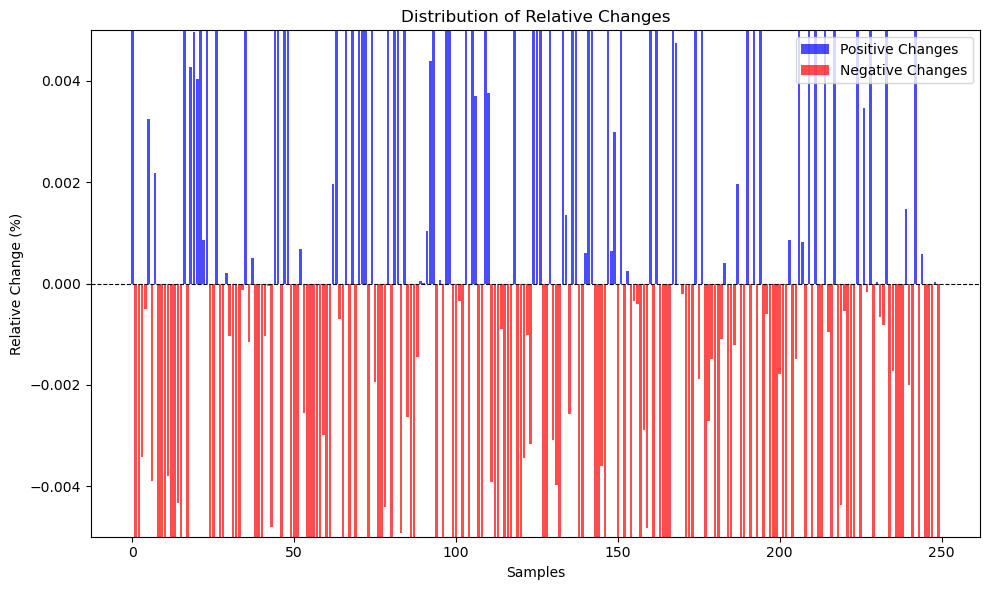

In [13]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC 32

In [14]:
tc32_bert_results = {}

for threshold in thresholds:

    attention_values_tc32 = apply_attention(path_attention, tc32_test, bert_model_tc32, bert_tokenizer_tc32, 
                                            f"attention_values_tc32_{threshold}_bert", device, only_load=only_load)
    
    top_tokens_tc32 = apply_thresholding(attention_values_tc32, threshold)

    tc32_bert_result = compare_probs(tc32_test,
                                     bert_full_text_preds_tc32,
                                     top_tokens_tc32,
                                     None,
                                     bert_model_tc32, bert_tokenizer_tc32,
                                     id2label=bert_id2label_tc32,
                                     device=device)

    tc32_bert_results[threshold] = (attention_values_tc32, tc32_bert_result)
    
    clear_gpu_memory()
    
show(tc32_bert_results[0.5][1])

  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_tc32_0.5_bert' saved.
'attention_values_tc32_0.5_bert' file shape: 250


  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_tc32_0.6_bert' saved.
'attention_values_tc32_0.6_bert' file shape: 250


  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_tc32_0.7_bert' saved.
'attention_values_tc32_0.7_bert' file shape: 250



Classification accuracy                             :  0.952
Explanations Contribution Score (ECS) of Full Text  :  0.991
Explanations Contribution Score (ECS) of Top Tokens :  0.92
Overall Relative Change (ORC) positive changes      :  0.057 %
Overall Relative Change (ORC) negative changes      : -8.551 %


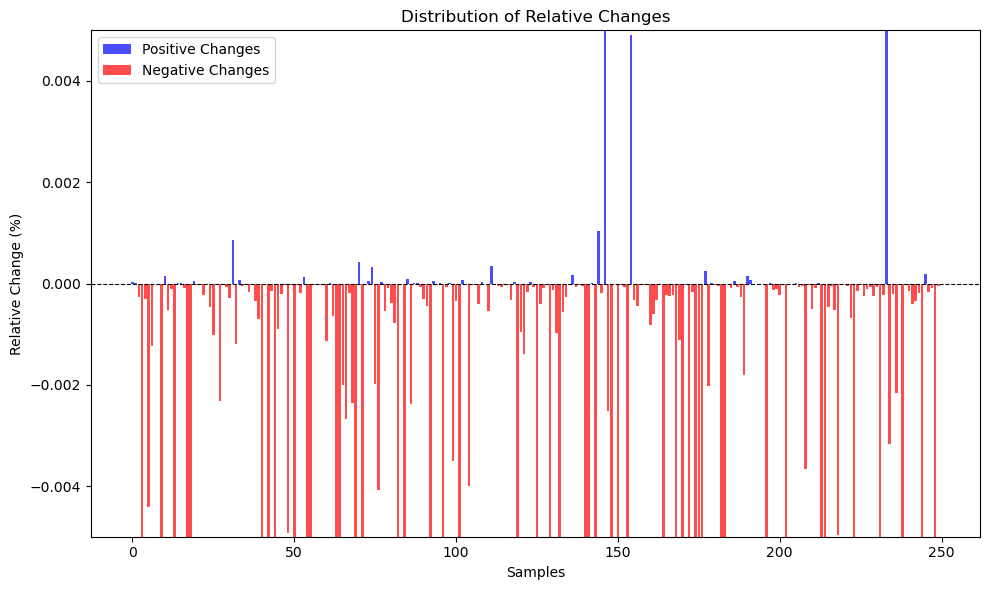


Classification accuracy                             :  0.952
Explanations Contribution Score (ECS) of Full Text  :  0.991
Explanations Contribution Score (ECS) of Top Tokens :  0.918
Overall Relative Change (ORC) positive changes      :  0.063 %
Overall Relative Change (ORC) negative changes      : -9.003 %


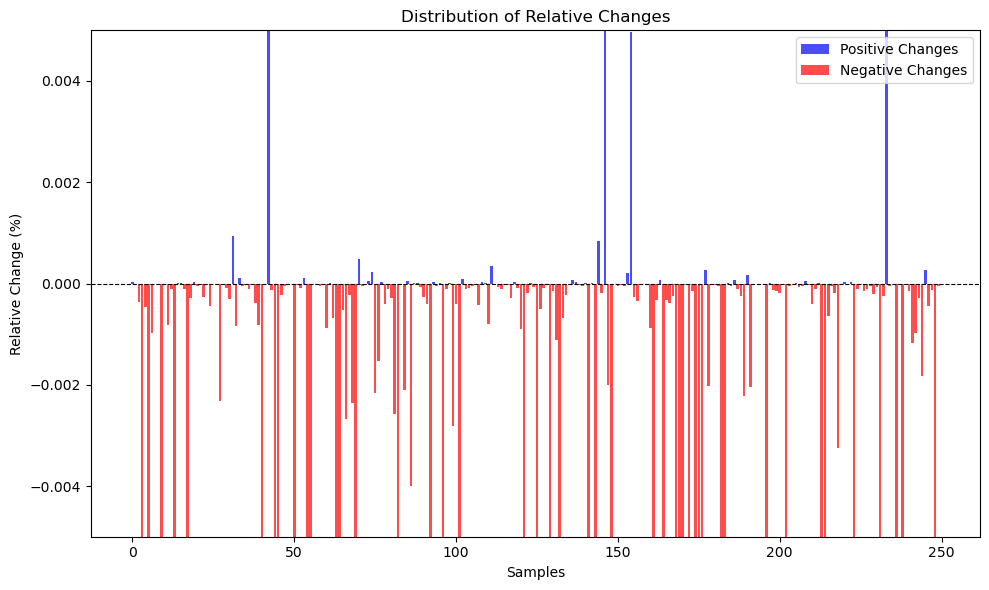


Classification accuracy                             :  0.952
Explanations Contribution Score (ECS) of Full Text  :  0.991
Explanations Contribution Score (ECS) of Top Tokens :  0.909
Overall Relative Change (ORC) positive changes      :  0.304 %
Overall Relative Change (ORC) negative changes      : -9.889 %


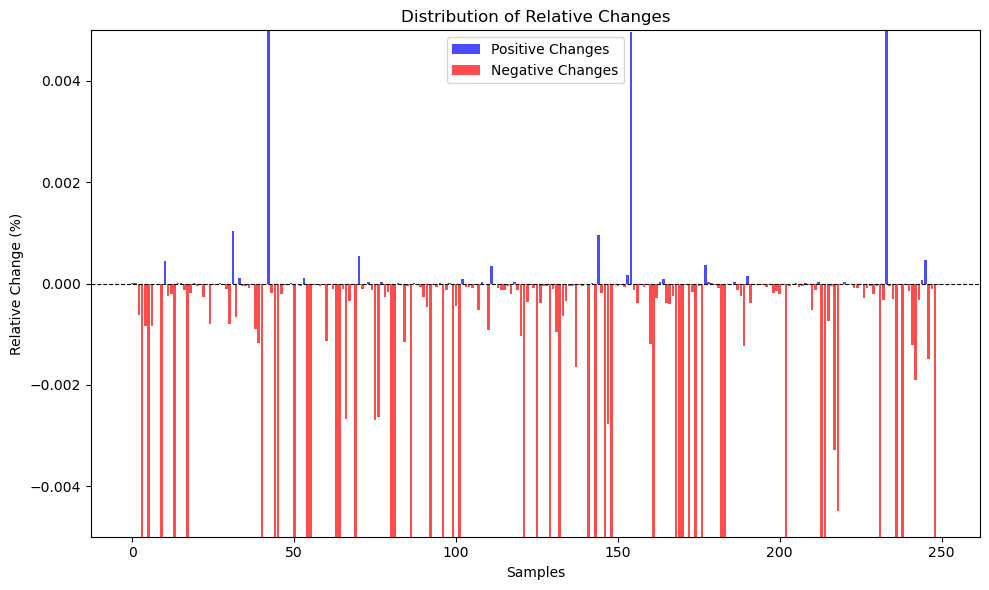

In [15]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

### TurkishBERTweet

#### Inference on Full Text

In [16]:
# Load TurkishBERTweet models

tbt_model_ttc4900, \
tbt_tokenizer_ttc4900, \
tbt_config_ttc4900, \
tbt_pipeline_text_ttc4900, \
tbt_label2id_ttc4900, \
tbt_id2label_ttc4900 = prepare_models(path_tbt_model_ttc4900, device)

tbt_model_tr_news, \
tbt_tokenizer_tr_news, \
tbt_config_tr_news, \
tbt_pipeline_text_tr_news, \
tbt_label2id_tr_news, \
tbt_id2label_tr_news = prepare_models(path_tbt_model_tr_news, device)

tbt_model_interpress, \
tbt_tokenizer_interpress, \
tbt_config_interpress, \
tbt_pipeline_text_interpress, \
tbt_label2id_interpress, \
tbt_id2label_interpress = prepare_models(path_tbt_model_interpress, device)

tbt_model_tc32, \
tbt_tokenizer_tc32, \
tbt_config_tc32, \
tbt_pipeline_text_tc32, \
tbt_label2id_tc32, \
tbt_id2label_tc32 = prepare_models(path_tbt_model_tc32, device)


'turkishbertweet_text_classification_fine_tuned_ttc4900' is loaded.

'turkishbertweet_text_classification_fine_tuned_tr_news' is loaded.

'turkishbertweet_text_classification_fine_tuned_interpress' is loaded.

'turkishbertweet_text_classification_fine_tuned_tc32' is loaded.


In [17]:
path_classification_results = "Data/Classification_Results/TurkishBERTweet/"

with open(path_classification_results + 'tbt_full_text_preds_ttc4900.pkl', 'rb') as file:
    tbt_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tr_news.pkl', 'rb') as file:
    tbt_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_interpress.pkl', 'rb') as file:
    tbt_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tc32.pkl', 'rb') as file:
    tbt_full_text_preds_tc32 = pickle.load(file)

In [18]:
tbt_full_text_preds_ttc4900 = tbt_full_text_preds_ttc4900[:num_samples]
tbt_full_text_preds_tr_news = tbt_full_text_preds_tr_news[:num_samples]
tbt_full_text_preds_interpress = tbt_full_text_preds_interpress[:num_samples]
tbt_full_text_preds_tc32 = tbt_full_text_preds_tc32[:num_samples]

#### TTC4900

In [19]:
ttc4900_tbt_results = {}

for threshold in thresholds:

    attention_values_ttc = apply_attention(path_attention, ttc4900_test, tbt_model_ttc4900, tbt_tokenizer_ttc4900, 
                                           f"attention_values_ttc_{threshold}_tbt", device, only_load=only_load)
    
    top_tokens_ttc4900 = apply_thresholding(attention_values_ttc, threshold)

    ttc4900_tbt_result = compare_probs(ttc4900_test,
                                       tbt_full_text_preds_ttc4900,
                                       top_tokens_ttc4900,
                                       None,
                                       tbt_model_ttc4900, tbt_tokenizer_ttc4900,
                                       id2label=tbt_id2label_ttc4900,
                                       device=device)

    ttc4900_tbt_results[threshold] = (attention_values_ttc, ttc4900_tbt_result)
    
    clear_gpu_memory()
    
show(ttc4900_tbt_results[0.5][1])

  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_ttc_0.5_tbt' saved.
'attention_values_ttc_0.5_tbt' file shape: 250


  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_ttc_0.6_tbt' saved.
'attention_values_ttc_0.6_tbt' file shape: 250


  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_ttc_0.7_tbt' saved.
'attention_values_ttc_0.7_tbt' file shape: 250



Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.987
Explanations Contribution Score (ECS) of Top Tokens :  0.823
Overall Relative Change (ORC) positive changes      :  0.357 %
Overall Relative Change (ORC) negative changes      : -28.593 %


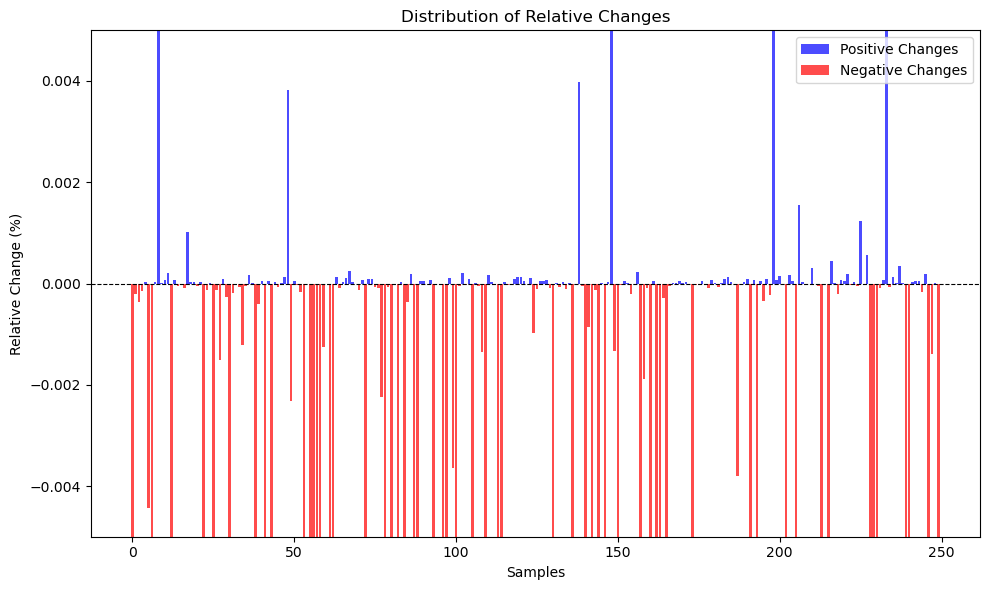


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.987
Explanations Contribution Score (ECS) of Top Tokens :  0.786
Overall Relative Change (ORC) positive changes      :  0.69 %
Overall Relative Change (ORC) negative changes      : -33.57 %


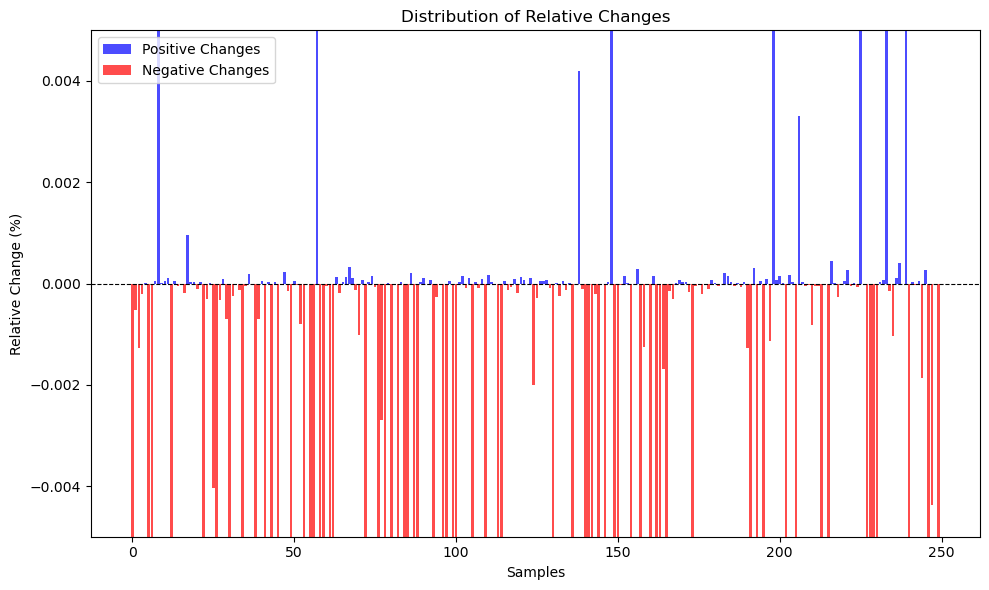


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.987
Explanations Contribution Score (ECS) of Top Tokens :  0.758
Overall Relative Change (ORC) positive changes      :  1.594 %
Overall Relative Change (ORC) negative changes      : -35.504 %


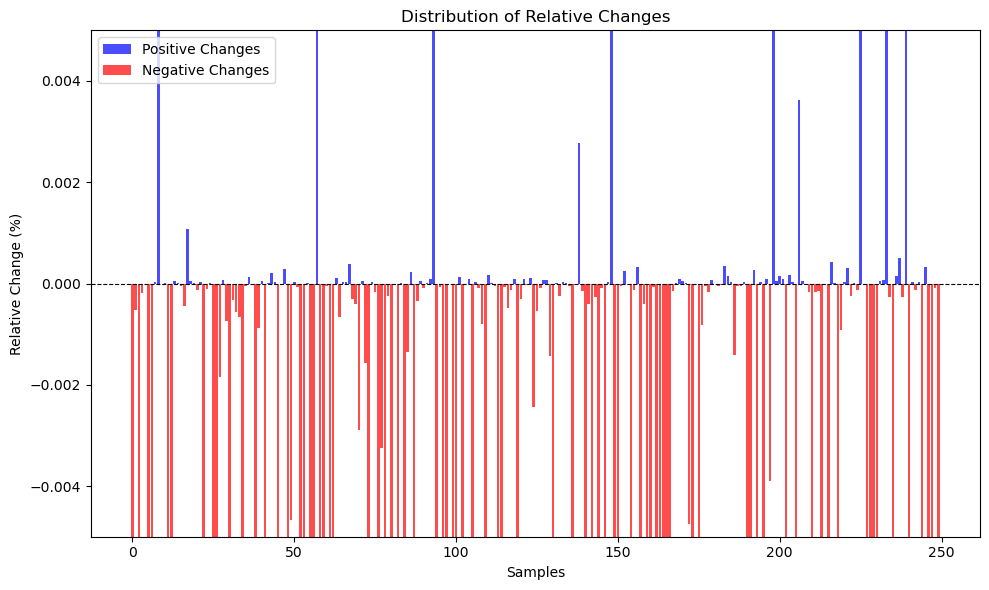

In [20]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [21]:
tr_news_tbt_results = {}

for threshold in thresholds:

    attention_values_tr_news = apply_attention(path_attention, tr_news_test, tbt_model_tr_news, tbt_tokenizer_tr_news, 
                                               f"attention_values_tr_news_{threshold}_tbt", device, only_load=only_load)
    
    top_tokens_tr_news = apply_thresholding(attention_values_tr_news, threshold)

    tr_news_tbt_result = compare_probs(tr_news_test,
                                       tbt_full_text_preds_tr_news,
                                       top_tokens_tr_news,
                                       None,
                                       tbt_model_tr_news, tbt_tokenizer_tr_news,
                                       id2label=tbt_id2label_tr_news,
                                       device=device)

    tr_news_tbt_results[threshold] = (attention_values_tr_news, tr_news_tbt_result)
    
    clear_gpu_memory()
    
show(tr_news_tbt_results[0.5][1])

  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_tr_news_0.5_tbt' saved.
'attention_values_tr_news_0.5_tbt' file shape: 250


  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_tr_news_0.6_tbt' saved.
'attention_values_tr_news_0.6_tbt' file shape: 250


  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_tr_news_0.7_tbt' saved.
'attention_values_tr_news_0.7_tbt' file shape: 250



Classification accuracy                             :  0.712
Explanations Contribution Score (ECS) of Full Text  :  0.798
Explanations Contribution Score (ECS) of Top Tokens :  0.614
Overall Relative Change (ORC) positive changes      :  7.116 %
Overall Relative Change (ORC) negative changes      : -31.417 %


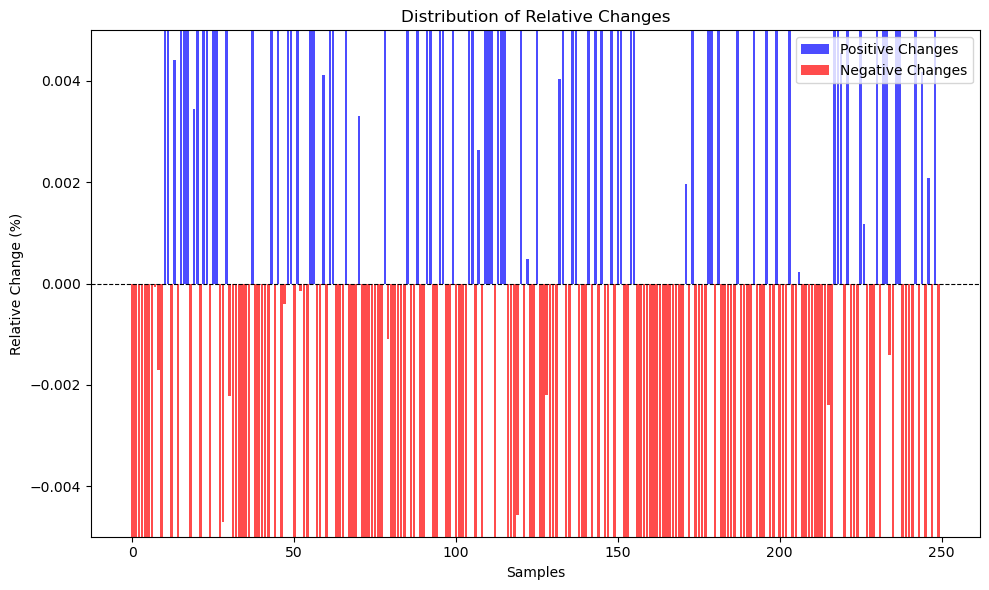


Classification accuracy                             :  0.712
Explanations Contribution Score (ECS) of Full Text  :  0.798
Explanations Contribution Score (ECS) of Top Tokens :  0.571
Overall Relative Change (ORC) positive changes      :  6.091 %
Overall Relative Change (ORC) negative changes      : -35.036 %


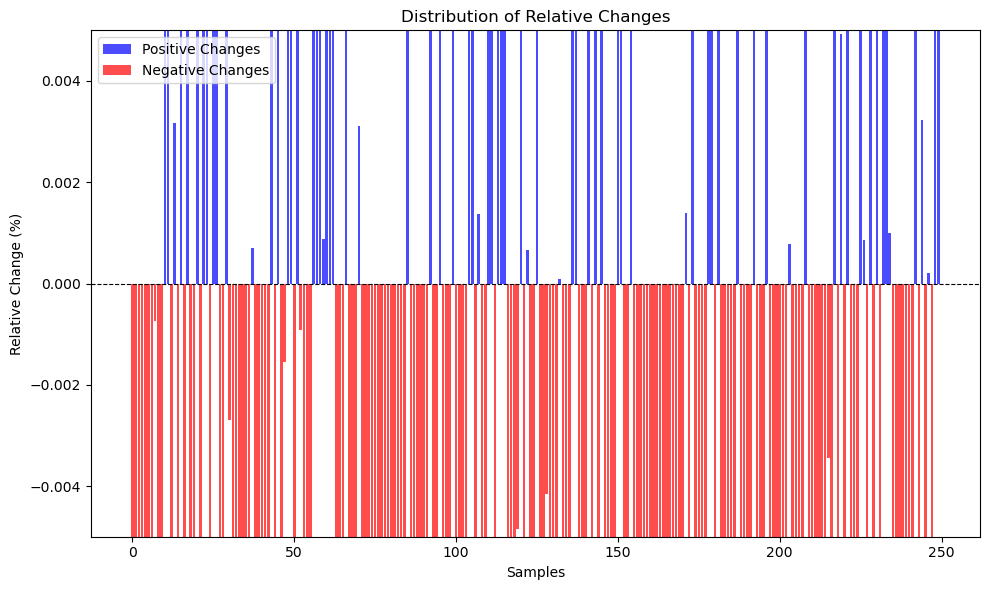


Classification accuracy                             :  0.712
Explanations Contribution Score (ECS) of Full Text  :  0.798
Explanations Contribution Score (ECS) of Top Tokens :  0.518
Overall Relative Change (ORC) positive changes      :  6.246 %
Overall Relative Change (ORC) negative changes      : -39.585 %


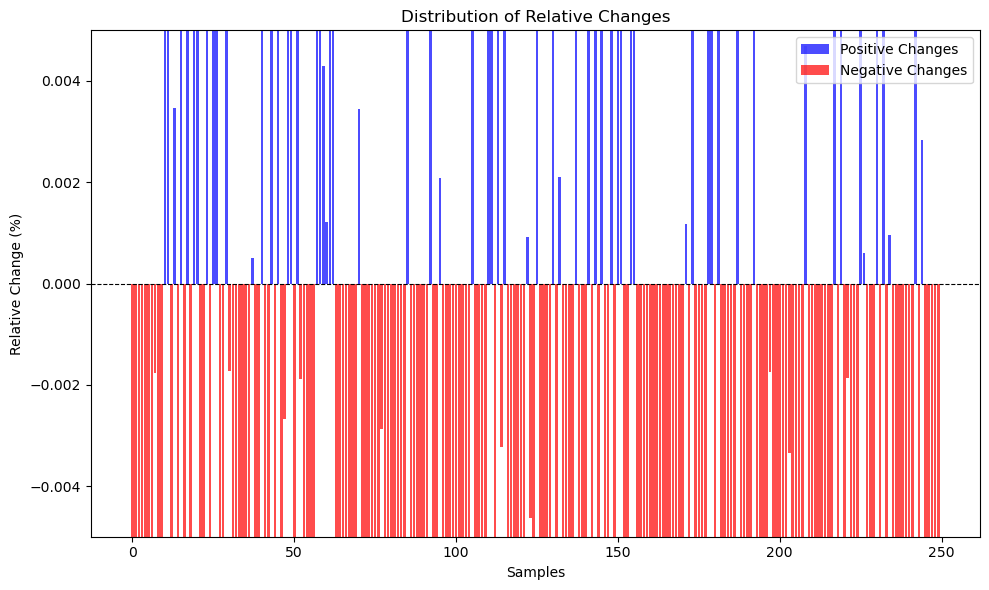

In [22]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [23]:
interpress_tbt_results = {}

for threshold in thresholds:

    attention_values_interpress = apply_attention(path_attention, interpress_test, tbt_model_interpress, tbt_tokenizer_interpress, 
                                                  f"attention_values_interpress_{threshold}_tbt", device, only_load=only_load)
    
    top_tokens_interpress = apply_thresholding(attention_values_interpress, threshold)

    interpress_tbt_result = compare_probs(interpress_test,
                                          tbt_full_text_preds_interpress,
                                          top_tokens_interpress,
                                          None,
                                          tbt_model_interpress, tbt_tokenizer_interpress,
                                          id2label=tbt_id2label_interpress,
                                          device=device)

    interpress_tbt_results[threshold] = (attention_values_interpress, interpress_tbt_result)
    
    clear_gpu_memory()
    
show(interpress_tbt_results[0.5][1])

  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_interpress_0.5_tbt' saved.
'attention_values_interpress_0.5_tbt' file shape: 250


  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_interpress_0.6_tbt' saved.
'attention_values_interpress_0.6_tbt' file shape: 250


  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_interpress_0.7_tbt' saved.
'attention_values_interpress_0.7_tbt' file shape: 250



Classification accuracy                             :  0.764
Explanations Contribution Score (ECS) of Full Text  :  0.878
Explanations Contribution Score (ECS) of Top Tokens :  0.622
Overall Relative Change (ORC) positive changes      :  5.635 %
Overall Relative Change (ORC) negative changes      : -46.511 %


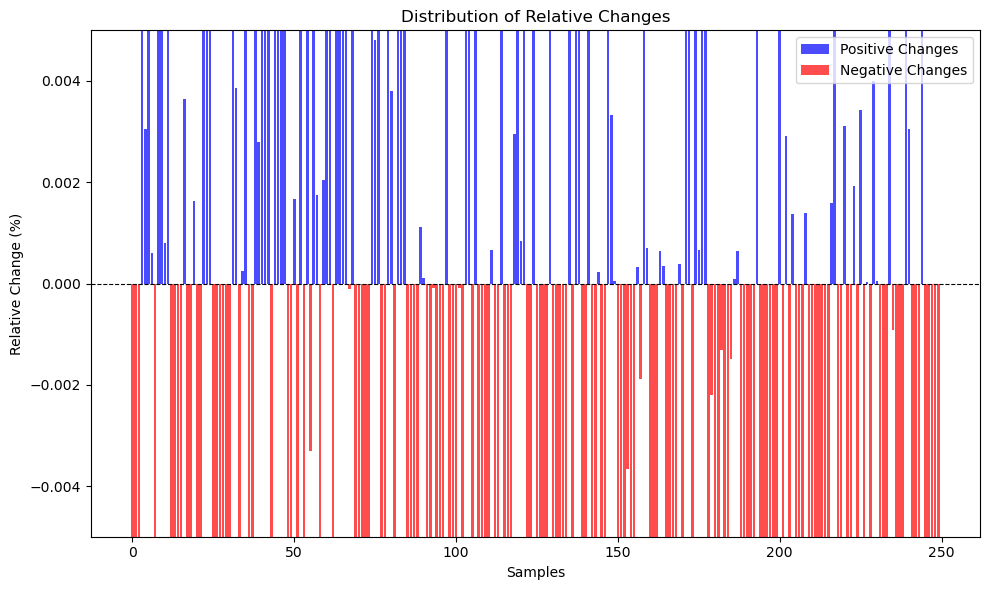


Classification accuracy                             :  0.764
Explanations Contribution Score (ECS) of Full Text  :  0.878
Explanations Contribution Score (ECS) of Top Tokens :  0.613
Overall Relative Change (ORC) positive changes      :  5.503 %
Overall Relative Change (ORC) negative changes      : -47.138 %


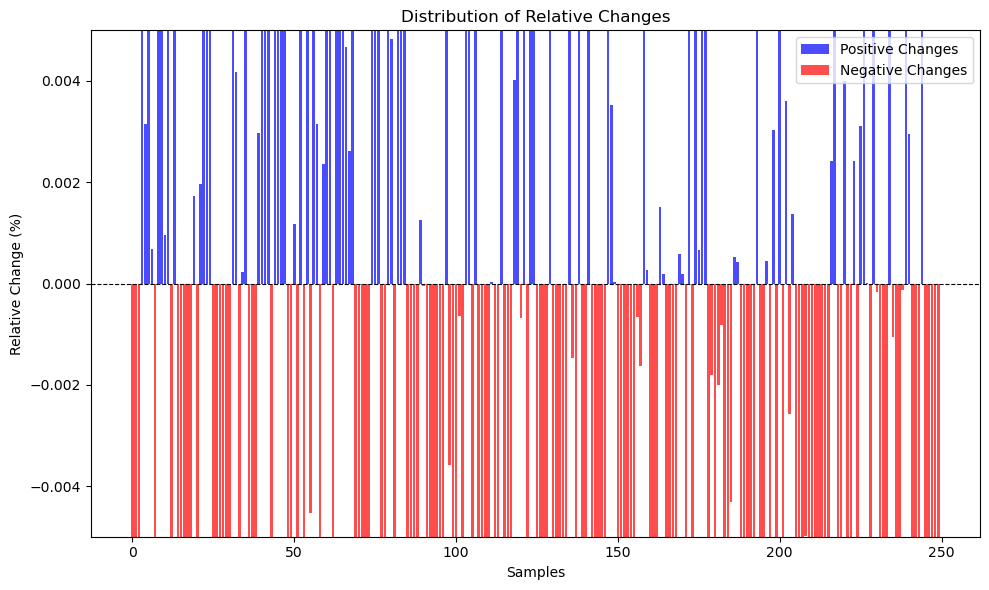


Classification accuracy                             :  0.764
Explanations Contribution Score (ECS) of Full Text  :  0.878
Explanations Contribution Score (ECS) of Top Tokens :  0.604
Overall Relative Change (ORC) positive changes      :  6.458 %
Overall Relative Change (ORC) negative changes      : -47.142 %


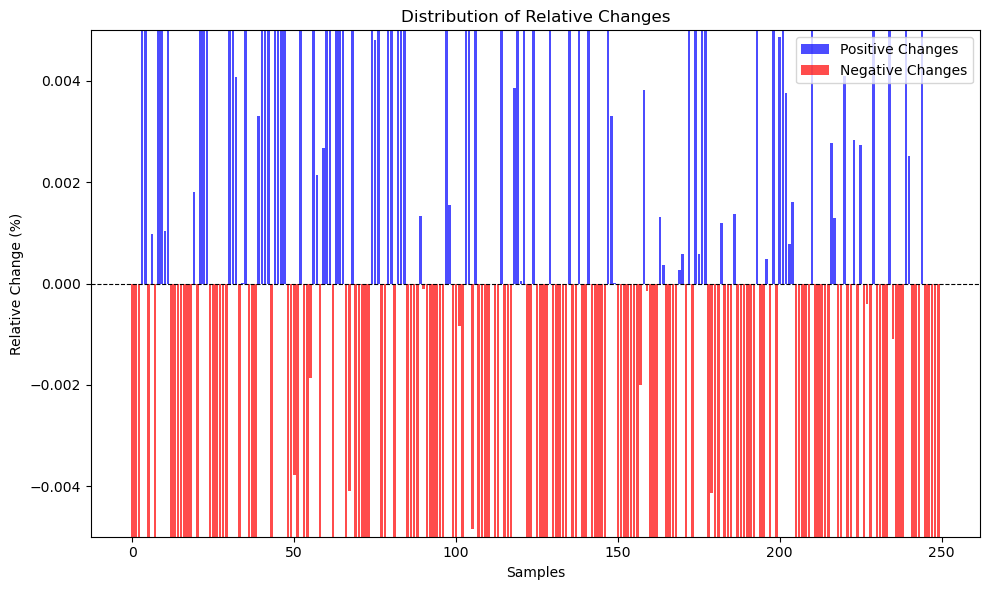

In [24]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC32

In [25]:
tc32_tbt_results = {}

for threshold in thresholds:

    attention_values_tc32 = apply_attention(path_attention, tc32_test, tbt_model_tc32, tbt_tokenizer_tc32, 
                                            f"attention_values_tc32_{threshold}_tbt", device, only_load=only_load)
    
    top_tokens_tc32 = apply_thresholding(attention_values_tc32, threshold)

    tc32_tbt_result = compare_probs(tc32_test,
                                    tbt_full_text_preds_tc32,
                                    top_tokens_tc32,
                                    None,
                                    tbt_model_tc32, tbt_tokenizer_tc32,
                                    id2label=tbt_id2label_tc32,
                                    device=device)

    tc32_tbt_results[threshold] = (attention_values_tc32, tc32_tbt_result)
    
    clear_gpu_memory()
    
show(tc32_tbt_results[0.5][1])

  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_tc32_0.5_tbt' saved.
'attention_values_tc32_0.5_tbt' file shape: 250


  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_tc32_0.6_tbt' saved.
'attention_values_tc32_0.6_tbt' file shape: 250


  0%|          | 0/250 [00:00<?, ?it/s]

File 'attention_values_tc32_0.7_tbt' saved.
'attention_values_tc32_0.7_tbt' file shape: 250



Classification accuracy                             :  0.912
Explanations Contribution Score (ECS) of Full Text  :  0.97
Explanations Contribution Score (ECS) of Top Tokens :  0.733
Overall Relative Change (ORC) positive changes      :  3.186 %
Overall Relative Change (ORC) negative changes      : -29.058 %


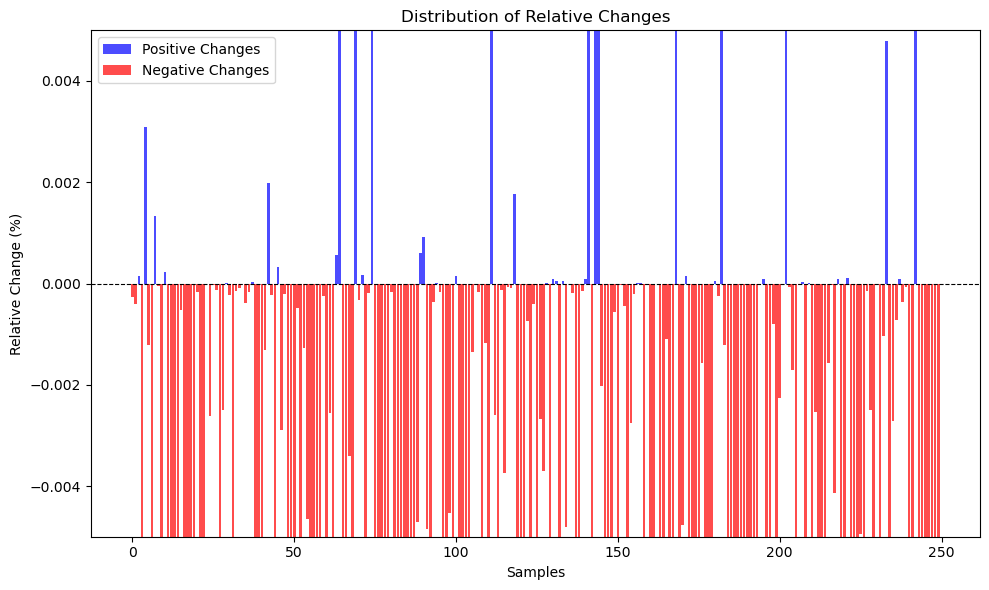


Classification accuracy                             :  0.912
Explanations Contribution Score (ECS) of Full Text  :  0.97
Explanations Contribution Score (ECS) of Top Tokens :  0.742
Overall Relative Change (ORC) positive changes      :  2.932 %
Overall Relative Change (ORC) negative changes      : -28.13 %


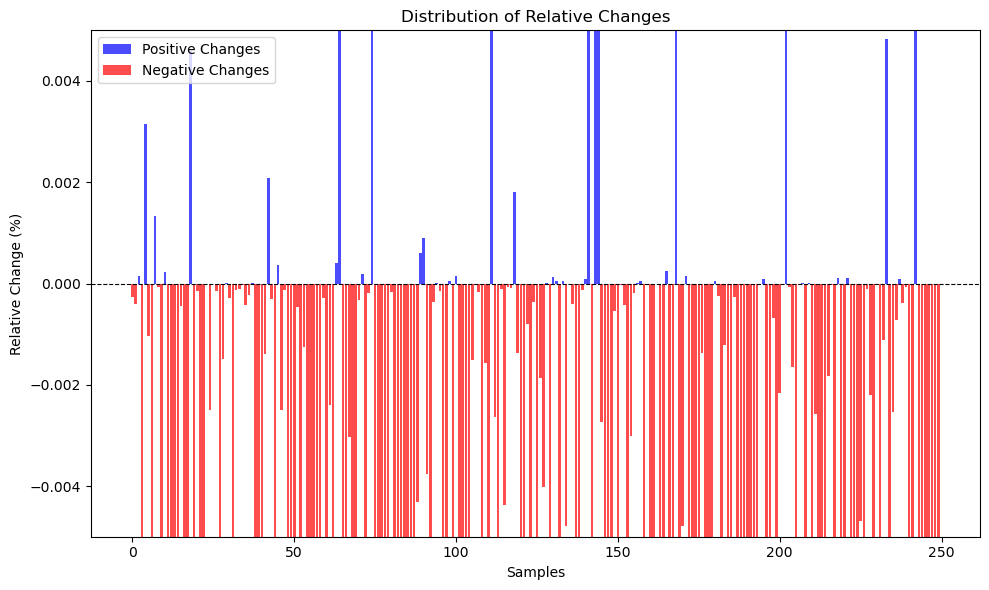


Classification accuracy                             :  0.912
Explanations Contribution Score (ECS) of Full Text  :  0.97
Explanations Contribution Score (ECS) of Top Tokens :  0.753
Overall Relative Change (ORC) positive changes      :  3.127 %
Overall Relative Change (ORC) negative changes      : -26.364 %


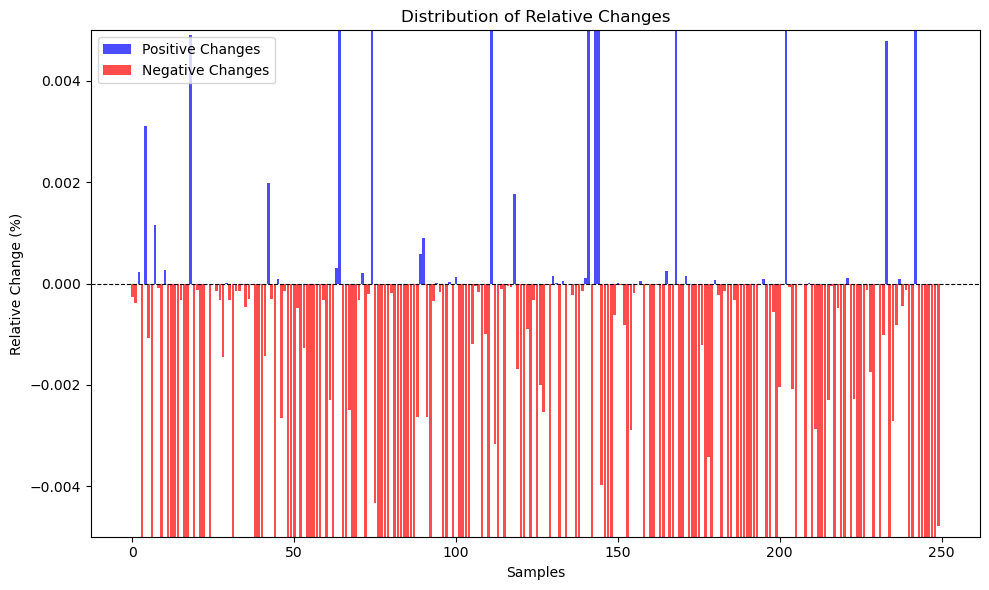

In [26]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

## Final Results

In [27]:
all_exp_results

Cl Acc  ECS FT  ECS TT  ORC (+)  ORC (-)
0    0.900   0.973   0.930    2.656   -7.822
1    0.900   0.973   0.922    2.563   -8.692
2    0.900   0.973   0.896    3.176  -11.549
3    0.776   0.856   0.714    6.253  -20.383
4    0.776   0.856   0.689    7.090  -23.579
5    0.776   0.856   0.664    8.357  -26.075
6    0.852   0.927   0.843    4.442  -16.496
7    0.852   0.927   0.843    5.163  -16.224
8    0.852   0.927   0.823    5.001  -18.838
9    0.952   0.991   0.920    0.057   -8.551
10   0.952   0.991   0.918    0.063   -9.003
11   0.952   0.991   0.909    0.304   -9.889
12   0.900   0.987   0.823    0.357  -28.593
13   0.900   0.987   0.786    0.690  -33.570
14   0.900   0.987   0.758    1.594  -35.504
15   0.712   0.798   0.614    7.116  -31.417
16   0.712   0.798   0.571    6.091  -35.036
17   0.712   0.798   0.518    6.246  -39.585
18   0.764   0.878   0.622    5.635  -46.511
19   0.764   0.878   0.613    5.503  -47.138
20   0.764   0.878   0.604    6.458  -47.142
21   0.912   0.970   0.733    3.186  -29.058
22   0.912   0.970   0.742    2.932  -28.130
23   0.912   0.970   0.753    3.127  -26.364

In [28]:
excel_file = path_reports + 'all_exp_results.xlsx'

with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    all_exp_results.to_excel(writer, sheet_name='Attention', index=False)